In [32]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set de Datos

El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de statsmodels.datasets.get_rdataset, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables.

Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

Nota: listado de todos los set de datos disponibles en Rdatasets

In [34]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

.. container::

   .. container::

      ======== ===============
      Carseats R Documentation
      ======== ===============

      .. rubric:: Sales of Child Car Seats
         :name: sales-of-child-car-seats

      .. rubric:: Description
         :name: description

      A simulated data set containing sales of child car seats at 400
      different stores.

      .. rubric:: Usage
         :name: usage

      .. code:: R

         Carseats

      .. rubric:: Format
         :name: format

      A data frame with 400 observations on the following 11 variables.

      ``Sales``
         Unit sales (in thousands) at each location

      ``CompPrice``
         Price charged by competitor at each location

      ``Income``
         Community income level (in thousands of dollars)

      ``Advertising``
         Local advertising budget for company at each location (in
         thousands of dollars)

      ``Population``
         Population size in region (in thousands)

      ``Pric

In [35]:
datos.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [36]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

In [37]:
datos.head(5)

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,0
1,111,48,16,260,83,Good,65,10,Yes,Yes,0
2,113,35,10,269,80,Medium,59,12,Yes,Yes,0
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,1


In [38]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CompPrice     400 non-null    int64 
 1   Income        400 non-null    int64 
 2   Advertising   400 non-null    int64 
 3   Population    400 non-null    int64 
 4   Price         400 non-null    int64 
 5   ShelveLoc     400 non-null    object
 6   Age           400 non-null    int64 
 7   Education     400 non-null    int64 
 8   Urban         400 non-null    object
 9   US            400 non-null    object
 10  ventas_altas  400 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 34.5+ KB


In [39]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

print(cat_cols)
print(numeric_cols)

['ShelveLoc', 'Urban', 'US']
['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']


In [9]:
# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [10]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


In [40]:
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

In [21]:
#Opcional para escalamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X2_train_temp = np.array(X_train_prep)
X2_test_temp = np.array(X_test_prep)
X2_train_temp.shape

(300, 14)

In [22]:
#Opcional para escalamiento
scaler.fit(X2_train_temp)
X2_TR = scaler.transform(X2_train_temp)
X2_TE = scaler.transform(X2_test_temp)

In [24]:
modelo.fit(X_train_prep, y_train)
#Opcional con escalamiento
modelo.fit(X2_TR, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 23


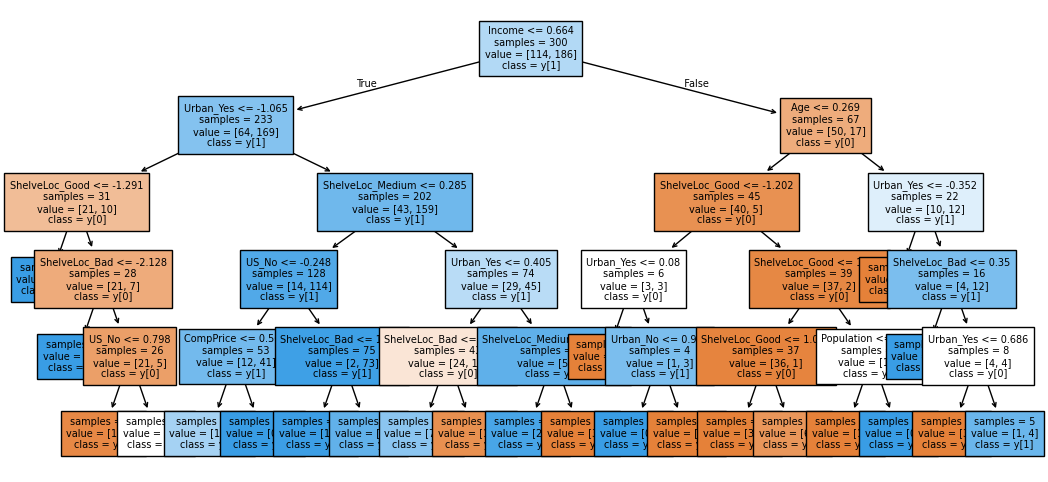

In [25]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = True,
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

In [26]:
y_test

,ventas_altas
234,0
42,0
303,0
155,1
342,1
...,...
291,1
210,1
200,1
147,0


In [28]:
predicciones = modelo.predict(X = X_test_prep,)
#Opcional con escalamiento
predicciones = modelo.predict(X = X2_TE,)
predicciones

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])

## Predicción y evaluación del modelo

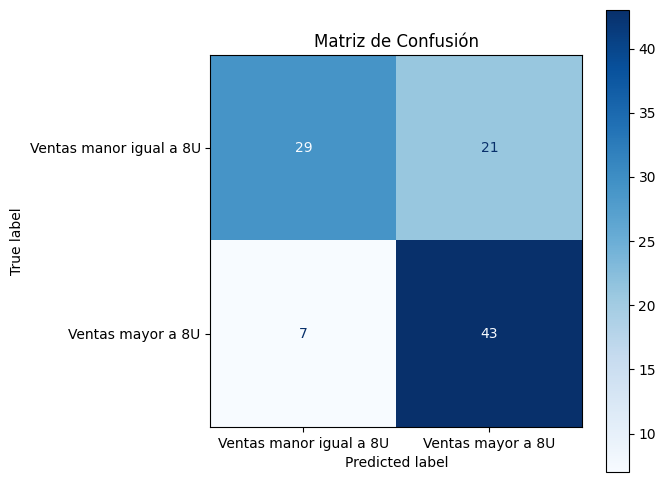

In [29]:
# Error de test del modelo
#-------------------------------------------------------------------------------
etiquetas = ['Ventas mayor a 8U' if c == 1 else 'Ventas manor igual a 8U' for c in modelo.classes_]
etiquetas
cm = confusion_matrix(
        y_true    = y_test,
        y_pred    = predicciones,
        labels=modelo.classes_
    )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas)
# Graficar
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')  # 'd' para enteros
plt.title("Matriz de Confusión")
plt.show()

In [30]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 72.0 %


In [31]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
#Opcional con escalamiento
predicciones = modelo.predict_proba(X = X2_TE)
predicciones[:10, :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.89473684, 0.10526316],
       [0.94444444, 0.05555556],
       [0.89473684, 0.10526316],
       [0.5       , 0.5       ],
       [0.07142857, 0.92857143],
       [0.94444444, 0.05555556],
       [0.01449275, 0.98550725],
       [0.29166667, 0.70833333]])